# TensorFlow deep NN
#### 用MNIST数据和TensorFlow包来深度学习的高级教程 
#### A high-level tutorial into Deep Learning using MNIST data and TensorFlow library.
by [@kakauandme](https://twitter.com/KaKaUandME) and [@thekoshkina](https://twitter.com/thekoshkina)

Accuracy: 0.99

**必备知识** 基础编码技巧，一点线性代数，特别是矩阵操作，可能也要明白如何图片是如何存储到计算机内存。和开始机器学习一样，我们建议学习吴恩达的课程

**Prerequisites:** fundamental coding skills, a bit of linear algebra, especially matrix operations and perhaps understanding how images are stored in computer memory. To start with machine learning, we suggest [coursera course](https://www.coursera.org/learn/machine-learning) by Andrew Ng.

笔记:
Note: 
通过随意分叉和调整常量，来调整网络行为和探索如何去改变算法表现和精准度。此外用TensorFlow 图部分也能调整学习目标

*Feel free to fork and adjust* CONSTANTS *to tweak network behaviour and explore how it changes algorithm performance and accuracy. Besides **TensorFlow graph** section can also be modified for learning purposes.*

非常推荐输出每个你不是100%了解的变量。也能使用你的本地环境让她可视化和调试

*It is highly recommended printing every variable that isn’t 100% clear for you. Also, [tensorboard](https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/index.html) can be used on a local environment for visualisation and debugging.*

## 包和设置 Libraries and settings

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

# settings
LEARNING_RATE = 1e-4
# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 25       
    
DROPOUT = 0.5
BATCH_SIZE = 50

# set to 0 to train on all available data
VALIDATION_SIZE = 2000

# image number to output
IMAGE_TO_DISPLAY = 10

## 数据预处理 Data preparation
开始，我们读取数据train.csv有42000行和785列。每一行代表一个手写的数字图片和一个标签用于表示这个图片是几的数字

To start, we read provided data. The *train.csv* file contains 42000 rows and 785 columns. Each row represents an image of a handwritten digit and a label with the value of this digit.

In [2]:
# read training data from CSV file 
data = pd.read_csv('train.csv')

print('data({0[0]},{0[1]})'.format(data.shape))
print (data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

每个图片是一个拉伸的数组的像素值

Every image is a "stretched" array of pixel values.

In [3]:
images = data.iloc[:,1:].values
images = images.astype(np.float)

# 数据乘以1/255，0-255->0-1
# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images({0[0]},{0[1]})'.format(images.shape))

images(42000,784)


吧784像素值转求出28*28像素

In this case it's 784 pixels => 28 * 28px

In [4]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


输出一个图片，我们改造像素值向量变成二维数组，这基本是一个灰度图像

To output one of the images, we reshape this long string of pixels into a 2-dimensional array, which is basically a grayscale image.

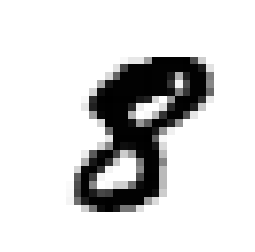

In [5]:
# 显示图片
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

# 输出图像，参数是第几行数据     
display(images[IMAGE_TO_DISPLAY])

相应的标签是0-9，描述每个图像是哪个数字

The corresponding labels are numbers between 0 and 9, describing which digit a given image is of.

In [6]:
# print(data)

# labels_flat = data[[0]].values.ravel()
# 获取标签列
labels_flat = data.iloc[:,0].values
# 打印标签列长度
print('labels_flat({0})'.format(len(labels_flat)))
# 打印第X行的图片对应的标签
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


在这个案例里，有10个不同的数字，标签，分类

In this case, there are ten different digits/labels/classes.

In [7]:
# unique是返回数组的唯一元素，然后获取形状位置0
labels_count = np.unique(labels_flat).shape[0]
# 打印总数
print('labels_count => {0}'.format(labels_count))

labels_count => 10


大多数分类程序使用独热向量（独热编码）。独热向量是一个包含1个1和剩余都是0的向量.在这个案例，数字几就是第几个是1的独热向量。

For most classification problems "one-hot vectors" are used. A one-hot vector is a vector that contains a single element equal to 1 and the rest of the elements equal to 0. In this case, the *nth* digit is represented as a zero vector with 1 in the *nth* position.

In [8]:
# 转换类标签标量到独热编码
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense, num_classes):
#    labels_dense = [1 0 1 ..., 7 6 9]
#    num_classes = 10
    num_labels = labels_dense.shape[0]
#    num_labels = 42000
    index_offset = np.arange(num_labels) * num_classes
#    index_offset = [     0     10     20 ..., 419970 419980 419990]
#    index_offset.shape = (42000,)
#    创建一个全0数组
    labels_one_hot = np.zeros((num_labels, num_classes))
#     print(labels_one_hot)
#    labels_one_hot.shape = (42000,10)
#    flat是一个循环迭代器,通过乘以10，来给每一行的数字打上one hot的1
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
#     print(labels_one_hot.flat[22])
    return labels_one_hot
# print(labels_one_hot.flat[21])
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


最后我们留出部分数据作为验证.在机器学习中，必须有一个独立的数据集，它不参与训练，用来确保我们训练的数据可以验证。

Lastly we set aside data for validation. It's essential in machine learning to have a separate dataset which doesn't take part in the training and is used to make sure that what we've learned can actually be generalised.

In [9]:
# 分割数据，分成验证集和训练集
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(40000,784)
validation_images(2000,784)


test_images(28000,784)
predicted_lables(28000)
predicted_lables[10] => 3.0


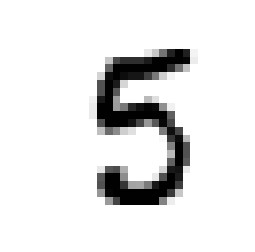

In [28]:
# read test data from CSV file 
test_images = pd.read_csv('test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

# save results
np.savetxt('submission_softmax.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

In [25]:
# 计算精准度
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [26]:
# 保存结果
def savecsv(test_prediction_np):
    np.savetxt('submission_uda_dr.csv', 
           np.c_[range(1,len(test_images)+1),test_prediction_np], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

In [29]:
# 0.90029
batch_size = 128  
regularation_param = 0.0001  
  
graph = tf.Graph()  
with graph.as_default():
    # -----------------------------------------1
    # 输入 
    # placeholder 插入一个待初始化的张量占位符
    # 重要事项：这个张量被求值时会产生错误。 
    # 它的值必须在Session.run(), Tensor.eval() 或 Operation.run() 中使用feed_dict的这个可选参数来填充。
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, labels_count))
    # 创建一个常量张量
    # tf_valid_dataset = Tensor("Const:0", shape=(10000, 784), dtype=float32)

    
    tf_valid_dataset = tf.constant(validation_images)
    tf_test_dataset = tf.constant(test_images)
    # ------------------------------------------2
    # 变量
    # 当你训练一个模型的时候，你使用变量去保存和更新参数。
    # 在Tensorflow中变量是内存缓冲区中保存的张量（tensor）。
    weights = tf.Variable(tf.truncated_normal([image_size, labels_count]))
    biases = tf.Variable(tf.zeros([labels_count]))
    print("image_size=%d" % image_size)
    # -------------------------------------------3
    # 训练计算.

    
    # 转换数据类型
    tf_valid_dataset = tf.to_float(tf_valid_dataset)
    tf_test_dataset = tf.to_float(tf_test_dataset)
    
    train_logits = tf.matmul(tf_train_dataset, weights) +  biases
    
#     print(type(tf_train_dataset))
#     print(type(tf_valid_dataset))
#     print(type(tf_test_dataset))
#     print(tf_train_dataset.dtype)
#     print(tf_valid_dataset.dtype)
#     print(tf_test_dataset.dtype)
    
#     print(tf_valid_dataset.shape)
#     print(weights.shape)
    
    
    valid_logits = tf.matmul(tf_valid_dataset, weights) + biases
    test_logits = tf.matmul(tf_test_dataset, weights) +  biases
    # reduce_mean可跨越维度的计算张量各元素的平均值
    # 计算loss是代价值，也就是我们要最小化的值
    # 第一个参数logits：就是神经网络最后一层的输出，
    # 如果有batch的话，它的大小就是[batchsize，num_classes]，单样本的话，大小就是num_classes
    # 第二个参数labels：实际的标签，大小同上
    # 第一步是先对网络最后一层的输出做一个softmax，这一步通常是求取输出属于某一类的概率
    # 第二步是softmax的输出向量[Y1，Y2,Y3...]和样本的实际标签做一个交叉熵
    # 注意！！！这个函数的返回值并不是一个数，而是一个向量.
    # 如果要求交叉熵，我们要再做一步tf.reduce_sum操作,就是对向量里面所有元素求和，最后才得到. 
    # 如果求loss，则要做一步tf.reduce_mean操作，对向量求均值！
    
    # 如果直接将l2_loss加到train_loss上，每次的train_loss都特别大，几乎只取决于l2_loss
    # 为了让原本的train_loss与l2_loss都能较好地对参数调整方向起作用，它们应当至少在同一个量级
    # 这里还有一个重要的点，Hyper Parameter: β
    # 我觉得这是一个拍脑袋参数，取什么值都行，但效果会不同，我这里解释一下我取β=0.001的理由
    # 为了让原本的train_loss与l2_loss都能较好地对参数调整方向起作用，它们应当至少在同一个量级
    # 观察不加l2_loss，step 0 时，train_loss在300左右
    # 加l2_loss后， step 0 时，train_loss在300000左右
    # 因此给l2_loss乘0.0001使之降到同一个量级
    # 原始 loss=18
    # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=train_logits, labels=tf_train_labels))
    # 原始L2后loss=58000
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits)) * tf.nn.l2_loss(weights)  
    # 使用Hyper Parameter 0.0001 相乘来降低L2的影响，使用后loss=16
    hpl2 = regularation_param * tf.nn.l2_loss(weights)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits))
    print(loss)
    loss = tf.add(loss, hpl2)

    
    #loss = tf.add(loss,
    # -------------------------------------------4
    # 最优化.因为深度学习常见的是对于梯度的优化，也就是说，优化器最后其实就是各种对于梯度下降算法的优化。 
    # 函数training()通过梯度下降法为最小化损失函数增加了相关的优化操作，在训练过程中，
    # 先实例化一个优化函数，比如 tf.train.GradientDescentOptimizer，并基于一定的学习率进行梯度优化训练：
    # learning_rate参数：要使用的学习率 
    # minimize：非常常用的一个函数 通过更新var_list来减小loss，这个函数就是前面compute_gradients() 和apply_gradients().的结合
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    
    #--------------------------------------------5
    # 预测训练, 验证,和测试数据.
    # tf.nn.softmax仅产生将softmax function应用于输入张量的结果。 
    # softmax 压扁输入，使sum(输入)= 1;这是一种正常化的方式。 
    # softmax的输出形状与输入相同 – 它只是对值进行归一化。 
    # softmax的输出可以解释为概率。
    # a = tf.constant(np.array([[.1, .3, .5, .9]]))
    # print s.run(tf.nn.softmax(a))
    # [[ 0.16838508  0.205666    0.25120102  0.37474789]]
    train_prediction = tf.nn.softmax(train_logits)
    valid_prediction = tf.nn.softmax(valid_logits)
    test_prediction = tf.nn.softmax(test_logits)

image_size=784
Tensor("Mean:0", shape=(), dtype=float32)


In [32]:
# 0.94586
batch_size = 128  
hidden_nodes = 1024
regularation_param = 0.0001  
keep_prob = 0.8
  
graph = tf.Graph()  
with graph.as_default():
    # -----------------------------------------1
    # 输入 
    # placeholder 插入一个待初始化的张量占位符
    # 重要事项：这个张量被求值时会产生错误。 
    # 它的值必须在Session.run(), Tensor.eval() 或 Operation.run() 中使用feed_dict的这个可选参数来填充。
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, labels_count))
    # 创建一个常量张量
    # tf_valid_dataset = Tensor("Const:0", shape=(10000, 784), dtype=float32)

    
    tf_valid_dataset = tf.constant(validation_images)
    tf_test_dataset = tf.constant(test_images)
    # ------------------------------------------2
    # 变量
    # 当你训练一个模型的时候，你使用变量去保存和更新参数。
    # 在Tensorflow中变量是内存缓冲区中保存的张量（tensor）。
    #weights = tf.Variable(tf.truncated_normal([image_size, labels_count]))
    #biases = tf.Variable(tf.zeros([labels_count]))
    
    
    # 第一层
    # truncated_normal 从一个正态分布片段中输出随机数值,
    # 生成的值会遵循一个指定了平均值和标准差的正态分布，只保留两个标准差以内的值，超出的值会被弃掉重新生成。
    # 返回 一个指定形状并用正态分布片段的随机值填充的张量
    weights1 = tf.Variable(tf.truncated_normal([image_size, hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    
    # 第二层
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes, labels_count]))
    biases2 = tf.Variable(tf.zeros([labels_count]))
    
    
    #print("image_size=%d" % image_size)
    # -------------------------------------------3
    # 训练计算.

    
    # 转换数据类型
    tf_valid_dataset = tf.to_float(tf_valid_dataset)
    tf_test_dataset = tf.to_float(tf_test_dataset)
    
    #使用dropout
    drop = tf.nn.dropout(tf_train_dataset, keep_prob=keep_prob)
    
    # train_logits = tf.matmul(tf_train_dataset, weights) +  biases
    # valid_logits = tf.matmul(tf_valid_dataset, weights) + biases
    # test_logits = tf.matmul(tf_test_dataset, weights) +  biases
    
    
    
    train_logits = tf.add(tf.matmul(drop, weights1), biases1)
    train_logits = tf.nn.relu(train_logits)
    train_logits = tf.add(tf.matmul(train_logits,weights2),biases2)

    valid_logits = tf.add(tf.matmul(tf_valid_dataset, weights1),biases1)
    valid_logits = tf.nn.relu(valid_logits)
    valid_logits = tf.add(tf.matmul(valid_logits,weights2),biases2)

    test_logits = tf.add(tf.matmul(tf_test_dataset, weights1),biases1)
    test_logits = tf.nn.relu(test_logits)
    test_logits = tf.add(tf.matmul(test_logits,weights2),biases2)
    
    
    
    # reduce_mean可跨越维度的计算张量各元素的平均值
    # 计算loss是代价值，也就是我们要最小化的值
    # 第一个参数logits：就是神经网络最后一层的输出，
    # 如果有batch的话，它的大小就是[batchsize，num_classes]，单样本的话，大小就是num_classes
    # 第二个参数labels：实际的标签，大小同上
    # 第一步是先对网络最后一层的输出做一个softmax，这一步通常是求取输出属于某一类的概率
    # 第二步是softmax的输出向量[Y1，Y2,Y3...]和样本的实际标签做一个交叉熵
    # 注意！！！这个函数的返回值并不是一个数，而是一个向量.
    # 如果要求交叉熵，我们要再做一步tf.reduce_sum操作,就是对向量里面所有元素求和，最后才得到. 
    # 如果求loss，则要做一步tf.reduce_mean操作，对向量求均值！
    
    # 如果直接将l2_loss加到train_loss上，每次的train_loss都特别大，几乎只取决于l2_loss
    # 为了让原本的train_loss与l2_loss都能较好地对参数调整方向起作用，它们应当至少在同一个量级
    # 这里还有一个重要的点，Hyper Parameter: β
    # 我觉得这是一个拍脑袋参数，取什么值都行，但效果会不同，我这里解释一下我取β=0.001的理由
    # 为了让原本的train_loss与l2_loss都能较好地对参数调整方向起作用，它们应当至少在同一个量级
    # 观察不加l2_loss，step 0 时，train_loss在300左右
    # 加l2_loss后， step 0 时，train_loss在300000左右
    # 因此给l2_loss乘0.0001使之降到同一个量级
    # 原始 loss=18
    # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=train_logits, labels=tf_train_labels))
    # 原始L2后loss=58000
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits)) * tf.nn.l2_loss(weights)  
    # 使用Hyper Parameter 0.0001 相乘来降低L2的影响，使用后loss=16
    hpl2 = regularation_param * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits))
    loss = tf.add(loss , hpl2)
    

    
    #loss = tf.add(loss,
    # -------------------------------------------4
    # 最优化.因为深度学习常见的是对于梯度的优化，也就是说，优化器最后其实就是各种对于梯度下降算法的优化。 
    # 函数training()通过梯度下降法为最小化损失函数增加了相关的优化操作，在训练过程中，
    # 先实例化一个优化函数，比如 tf.train.GradientDescentOptimizer，并基于一定的学习率进行梯度优化训练：
    # learning_rate参数：要使用的学习率 
    # minimize：非常常用的一个函数 通过更新var_list来减小loss，这个函数就是前面compute_gradients() 和apply_gradients().的结合
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    
    #--------------------------------------------5
    # 预测训练, 验证,和测试数据.
    # tf.nn.softmax仅产生将softmax function应用于输入张量的结果。 
    # softmax 压扁输入，使sum(输入)= 1;这是一种正常化的方式。 
    # softmax的输出形状与输入相同 – 它只是对值进行归一化。 
    # softmax的输出可以解释为概率。
    # a = tf.constant(np.array([[.1, .3, .5, .9]]))
    # print s.run(tf.nn.softmax(a))
    # [[ 0.16838508  0.205666    0.25120102  0.37474789]]
    train_prediction = tf.nn.softmax(train_logits)
    valid_prediction = tf.nn.softmax(valid_logits)
    test_prediction = tf.nn.softmax(test_logits)

In [35]:
num_steps = 3001  
print (test_images.shape[0]//batch_size)
with tf.Session(graph=graph) as session:  
    tf.initialize_all_variables().run()  
    print("Initialized")  
    for step in range(num_steps):  
        # 在训练数据中选择一个已被随机化的偏移量.
        # 提醒: 我们能使用更好的随机化穿过所有数据.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)  
        # 生成一个小批量数据
        batch_data = train_images[offset:(offset + batch_size), :]  
        batch_labels = train_labels[offset:(offset + batch_size), :]  
        # feed_dict的作用是给使用placeholder创建出来的tensor赋值。
        # 其实，他的作用更加广泛：feed 使用一个 值临时替换一个 op 的输出结果. 
        # 你可以提供 feed 数据作为 run() 调用的参数. feed 只在调用它的方法内有效, 方法结束, feed 就会消失.
        #  传递值到tf的命名空间  
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}  
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)  
        if (step % 500 == 0):  
            print("Minibatch loss at step %d: %f" % (step, l))  
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))  
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), validation_labels))  
    # 获取结果，用于保存
    test_prediction_np = test_prediction.eval()
    test_prediction_np = np.argmax(test_prediction_np, 1)
    savecsv(test_prediction_np)
    #predicted_lables = np.zeros(test_images.shape[0])
    #for i in range(0,test_images.shape[0]//BATCH_SIZE):
    #    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = test_prediction.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], keep_prob: 1.0})

    #print(test_prediction.eval().shape)


#     predictions = np.argmax(sess.run(y_pred, feed_dict={X: X_test}), 1)  
    # print("Test accuracy: %.1f%% with regularation_param = %f " %( accuracy(test_prediction.eval(), test_labels), regularation_param)) 

218
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 259.307404
Minibatch accuracy: 14.1%
Validation accuracy: 26.1%
Minibatch loss at step 500: 31.825253
Minibatch accuracy: 96.1%
Validation accuracy: 93.0%
Minibatch loss at step 1000: 28.782307
Minibatch accuracy: 96.9%
Validation accuracy: 93.7%
Minibatch loss at step 1500: 27.505709
Minibatch accuracy: 93.0%
Validation accuracy: 93.0%
Minibatch loss at step 2000: 26.266083
Minibatch accuracy: 92.2%
Validation accuracy: 93.9%
Minibatch loss at step 2500: 24.772188
Minibatch accuracy: 94.5%
Validation accuracy: 93.3%


In [44]:
# 0.98000
batch_size = 128
# 隐藏节点
hidden_nodes = 2048
# L2缩放率
regularation_param = 0.0001  

graph = tf.Graph()  
def compute_logits(data, weightss, biasess, dropout_vals=None):  
    temp = data  
    if dropout_vals:  
        for w,b,d in zip(weightss[:-1], biasess[:-1], dropout_vals[:-1]):  
            temp = tf.nn.relu_layer(tf.nn.dropout(temp, d), w, b)  
        temp = tf.matmul(temp, weightss[-1]) + biasess[-1]  
    else:  
        for w,b in zip(weightss[:-1], biasess[:-1]):
            temp = tf.nn.relu_layer(temp, w, b)  
        temp = tf.matmul(temp, weightss[-1]) + biasess[-1]  
    return temp  
with graph.as_default():
    # -----------------------------------------1
    # 输入 
    # placeholder 插入一个待初始化的张量占位符
    # 重要事项：这个张量被求值时会产生错误。 
    # 它的值必须在Session.run(), Tensor.eval() 或 Operation.run() 中使用feed_dict的这个可选参数来填充。
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, labels_count))
    

    
    # 创建一个常量张量
    # tf_valid_dataset = Tensor("Const:0", shape=(10000, 784), dtype=float32)
    tf_valid_dataset = tf.constant(validation_images)
    tf_test_dataset = tf.constant(test_images)
    
    # 转换数据类型
    tf_valid_dataset = tf.to_float(tf_valid_dataset)
    tf_test_dataset = tf.to_float(tf_test_dataset)
    # ------------------------------------------2
    # 变量
    # #该函数返回以下结果
    # decayed_learning_rate = learning_rate *
    # decay_rate ^ (global_step / decay_steps)
    # 初始的学习速率
    starter_learning_rate = 0.3
    # 全局的step，与 decay_step 和 decay_rate一起决定了 learning rate的变化
    global_step = tf.Variable(0, trainable=False)
    # 衰减速度
    decay_steps = 200
    # 衰减系数
    decay_rate = 0.3
    # 如果staircase=True，那就表明每decay_steps次计算学习速率变化，更新原始学习速率.
    # 如果是False，那就是每一步都更新学习速率
    staircase = True
    # 指数衰减:法通过这个函数，可以先使用较大的学习率来快速得到一个比较优的解，然后随着迭代的继续逐步减小学习率，使得模型在训练后期更加稳定
    # 87.7% 仅仅指数衰减
    learning_rate = tf.train.exponential_decay(starter_learning_rate,global_step,decay_steps,decay_rate,staircase)
    
    # 当你训练一个模型的时候，你使用变量去保存和更新参数。
    # 在Tensorflow中变量是内存缓冲区中保存的张量（tensor）。

    # 第一层
    # truncated_normal 从一个正态分布片段中输出随机数值,
    # 生成的值会遵循一个指定了平均值和标准差的正态分布，只保留两个标准差以内的值，超出的值会被弃掉重新生成。
    # 返回 一个指定形状并用正态分布片段的随机值填充的张量
    # 数字平方根
    x = 2.0
    weights1 = tf.Variable(tf.truncated_normal([image_size, hidden_nodes], stddev = np.sqrt(x / hidden_nodes)))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    
    # 第二层
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes, int(hidden_nodes / 2)], stddev = np.sqrt(x / hidden_nodes / 2)))
    biases2 = tf.Variable(tf.zeros([hidden_nodes / 2]))
    hidden_nodes = int(hidden_nodes / 2)
    
    # 第三层
    weights3 = tf.Variable(tf.truncated_normal([hidden_nodes, int(hidden_nodes / 2)], stddev = np.sqrt(x / hidden_nodes / 2)))
    biases3 = tf.Variable(tf.zeros([hidden_nodes / 2]))
    hidden_nodes = int(hidden_nodes / 2)
    
    # 第四层 94.5
    weights4 = tf.Variable(tf.truncated_normal([hidden_nodes, int(hidden_nodes / 2)], stddev = np.sqrt(x / hidden_nodes / 2)))
    biases4 = tf.Variable(tf.zeros([hidden_nodes / 2]))
    hidden_nodes = int(hidden_nodes / 2)
    
    # 第五层 94.5
    weights5 = tf.Variable(tf.truncated_normal([hidden_nodes, int(hidden_nodes / 2)], stddev = np.sqrt(x / hidden_nodes / 2)))
    biases5 = tf.Variable(tf.zeros([hidden_nodes / 2]))
    hidden_nodes = int(hidden_nodes / 2)
    
    # 最后一层
    weights_end = tf.Variable(tf.truncated_normal([hidden_nodes, labels_count], stddev = np.sqrt(x / labels_count)))
    biases_end  = tf.Variable(tf.zeros([labels_count]))
    
    # -------------------------------------------3
    # 训练计算.
    # logits = tf.matmul(tf_train_dataset, weights) + biases
    # DropDown的保留概率
    keep_prob = 0.8
    drop = tf.nn.dropout(tf_train_dataset, keep_prob=keep_prob)
    
    train_logits = compute_logits(tf_train_dataset, [weights1, weights2, weights3,weights4,weights5, weights_end], 
                                  [biases1,biases2,biases3,biases4,biases5, biases_end],  
                            dropout_vals=(1.0,0.95,0.95,0.95,0.95,1.0))
    
    # train_logits = tf.add(tf.matmul(drop, weights1),biases1)
    # train_logits = tf.nn.relu(train_logits)
    # train_logits = tf.add(tf.matmul(train_logits,weights2),biases2)

    valid_logits = compute_logits(tf_valid_dataset, [weights1, weights2, weights3,weights4,weights5, weights_end], 
                              [biases1,biases2,biases3,biases4,biases5, biases_end])
    
    # valid_logits = tf.add(tf.matmul(tf_valid_dataset, weights1),biases1)
    # valid_logits = tf.nn.relu(valid_logits)
    # valid_logits = tf.add(tf.matmul(valid_logits,weights2),biases2)

    test_logits = compute_logits(tf_test_dataset, [weights1, weights2, weights3,weights4,weights5, weights_end], 
                              [biases1,biases2,biases3,biases4,biases5, biases_end])
    
    # test_logits = tf.add(tf.matmul(tf_test_dataset, weights1),biases1)
    # test_logits = tf.nn.relu(test_logits)
    # test_logits = tf.add(tf.matmul(test_logits,weights2),biases2)
    
    # reduce_mean可跨越维度的计算张量各元素的平均值
    # 计算loss是代价值，也就是我们要最小化的值
    # 第一个参数logits：就是神经网络最后一层的输出，
    # 如果有batch的话，它的大小就是[batchsize，num_classes]，单样本的话，大小就是num_classes
    # 第二个参数labels：实际的标签，大小同上
    # 第一步是先对网络最后一层的输出做一个softmax，这一步通常是求取输出属于某一类的概率
    # 第二步是softmax的输出向量[Y1，Y2,Y3...]和样本的实际标签做一个交叉熵
    # 注意！！！这个函数的返回值并不是一个数，而是一个向量.
    # 如果要求交叉熵，我们要再做一步tf.reduce_sum操作,就是对向量里面所有元素求和，最后才得到. 
    # 如果求loss，则要做一步tf.reduce_mean操作，对向量求均值！
    
    # 如果直接将l2_loss加到train_loss上，每次的train_loss都特别大，几乎只取决于l2_loss
    # 为了让原本的train_loss与l2_loss都能较好地对参数调整方向起作用，它们应当至少在同一个量级
    # 这里还有一个重要的点，Hyper Parameter: β
    # 我觉得这是一个拍脑袋参数，取什么值都行，但效果会不同，我这里解释一下我取β=0.001的理由
    # 为了让原本的train_loss与l2_loss都能较好地对参数调整方向起作用，它们应当至少在同一个量级
    # 观察不加l2_loss，step 0 时，train_loss在300左右
    # 加l2_loss后， step 0 时，train_loss在300000左右
    # 因此给l2_loss乘0.0001使之降到同一个量级
    # 原始 loss=18
    # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=train_logits, labels=tf_train_labels))
    # 原始L2后loss=58000
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits)) * tf.nn.l2_loss(weights)  
    # 使用Hyper Parameter 0.0001 相乘来降低L2的影响，使用后loss=16
    #hpl2 = regularation_param * tf.nn.l2_loss(weights)
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits))
    #loss = tf.add(loss, hpl2)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits)) + regularation_param * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))  

    
    #loss = tf.add(loss,
    # -------------------------------------------4
    # 最优化.因为深度学习常见的是对于梯度的优化，也就是说，优化器最后其实就是各种对于梯度下降算法的优化。 
    # 函数training()通过梯度下降法为最小化损失函数增加了相关的优化操作，在训练过程中，
    # 先实例化一个优化函数，比如 tf.train.GradientDescentOptimizer，并基于一定的学习率进行梯度优化训练：
    # learning_rate参数：要使用的学习率 
    # minimize：非常常用的一个函数 通过更新var_list来减小loss，这个函数就是前面compute_gradients() 和apply_gradients().的结合
    optimizer = tf.train.GradientDescentOptimizer(0.03).minimize(loss, global_step=global_step)
    
    
    #--------------------------------------------5
    # 预测训练, 验证,和测试数据.
    # tf.nn.softmax仅产生将softmax function应用于输入张量的结果。 
    # softmax 压扁输入，使sum(输入)= 1;这是一种正常化的方式。 
    # softmax的输出形状与输入相同 – 它只是对值进行归一化。 
    # softmax的输出可以解释为概率。
    # a = tf.constant(np.array([[.1, .3, .5, .9]]))
    # print s.run(tf.nn.softmax(a))
    # [[ 0.16838508  0.205666    0.25120102  0.37474789]]
    print(train_logits.get_shape())
    train_prediction = tf.nn.softmax(train_logits)
    valid_prediction = tf.nn.softmax(valid_logits)
    test_prediction = tf.nn.softmax(test_logits)

(128, 10)


In [46]:
num_steps = 10001  
  
with tf.Session(graph=graph) as session:  
    tf.initialize_all_variables().run()  
    print("Initialized")  
    for step in range(num_steps):  
        # 在训练数据中选择一个已被随机化的偏移量.
        # 提醒: 我们能使用更好的随机化穿过所有数据.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)  
        # 生成一个小批量数据
        batch_data = train_images[offset:(offset + batch_size), :]  
        batch_labels = train_labels[offset:(offset + batch_size), :]  
        # feed_dict的作用是给使用placeholder创建出来的tensor赋值。
        # 其实，他的作用更加广泛：feed 使用一个 值临时替换一个 op 的输出结果. 
        # 你可以提供 feed 数据作为 run() 调用的参数. feed 只在调用它的方法内有效, 方法结束, feed 就会消失.
        #  传递值到tf的命名空间  
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}  
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)  
        if (step % 500 == 0):  
            print("Minibatch loss at step %d: %f" % (step, l))  
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))  
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), validation_labels))  
    # 获取结果，用于保存
    test_prediction_np = test_prediction.eval()
    test_prediction_np = np.argmax(test_prediction_np, 1)
    savecsv(test_prediction_np)
    

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 2.404335
Minibatch accuracy: 10.9%
Validation accuracy: 15.2%
Minibatch loss at step 500: 0.325492
Minibatch accuracy: 93.0%
Validation accuracy: 94.0%
Minibatch loss at step 1000: 0.186428
Minibatch accuracy: 96.9%
Validation accuracy: 96.2%
Minibatch loss at step 1500: 0.168846
Minibatch accuracy: 97.7%
Validation accuracy: 96.8%
Minibatch loss at step 2000: 0.198202
Minibatch accuracy: 96.9%
Validation accuracy: 97.5%
Minibatch loss at step 2500: 0.136462
Minibatch accuracy: 99.2%
Validation accuracy: 97.7%
Minibatch loss at step 3000: 0.152722
Minibatch accuracy: 98.4%
Validation accuracy: 97.8%
Minibatch loss at step 3500: 0.117042
Minibatch accuracy: 100.0%
Validation accuracy: 97.8%
Minibatch loss at step 4000: 0.128496
Minibatch accuracy: 98.4%
Validation accuracy: 97.9%
Minibatch loss at step 4500: 0.125471
Minibatch accuracy: 99.2%
Validation accuracy: 97.8%
Minibat

## Reference
- [Deep MNIST for Experts](https://www.tensorflow.org/versions/master/tutorials/mnist/pros/index.html#deep-mnist-for-experts)
- [A Convolutional Network implementation example using TensorFlow library](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3%20-%20Neural%20Networks/convolutional_network.ipynb)
- [Digit recognizer in Python using CNN](https://www.kaggle.com/kobakhit/digit-recognizer/digit-recognizer-in-python-using-cnn)
- [Deep Learning in a Nutshell: Core Concepts](http://devblogs.nvidia.com/parallelforall/deep-learning-nutshell-core-concepts/)